In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor

In [2]:
my_data=pd.read_csv('../Python_New_Work/train.csv')

In [3]:
my_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Our target variable is Sales Price



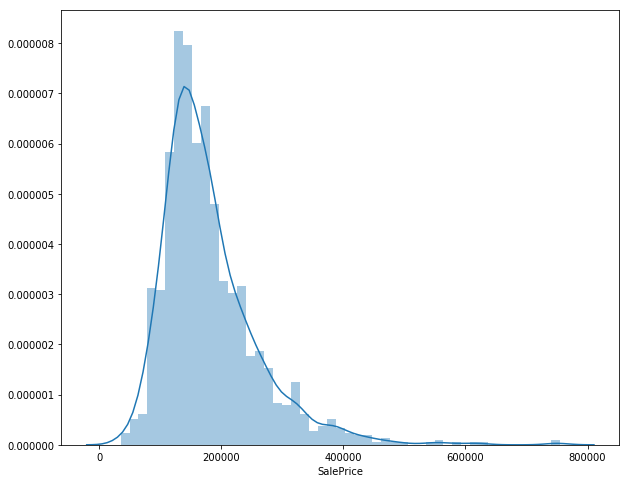

In [4]:
plt.subplots(figsize=(10,8))
sns.distplot(my_data['SalePrice'])
plt.show()

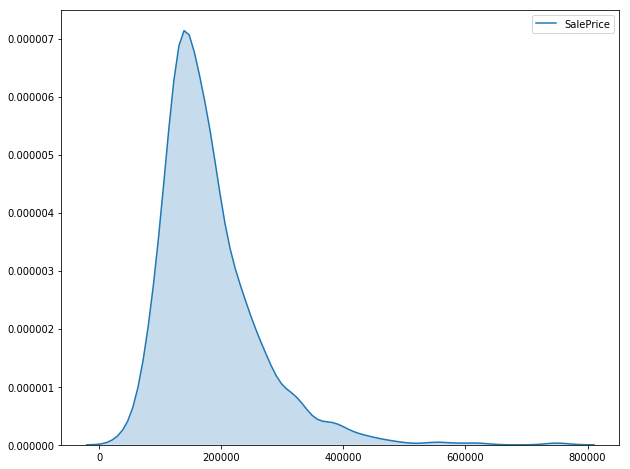

In [5]:
plt.subplots(figsize=(10,8))
sns.kdeplot(my_data['SalePrice'],shade=True)
plt.show()

### GrLivArea: Above grade (ground) living area square feet
GrLivArea vs SalesPrice

In [6]:
var='GrLivArea'

In [7]:
data=pd.concat([my_data['SalePrice'],my_data[var]],axis=1)


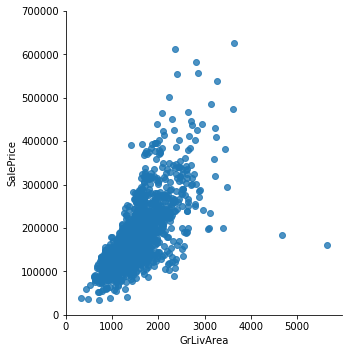

In [8]:
sns.lmplot(x=var,y='SalePrice',data=data,fit_reg=False)
plt.ylim( (0,700000))
plt.show()

##### It seems that 'SalePrice' and 'GrLivArea' are really old friends, with a linear relationship.

#### TotalBsmtSF: Total square feet of basement area
TotalBsmtSF vs SalePrice

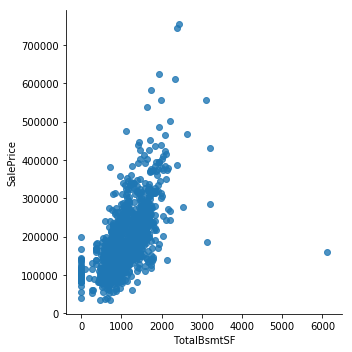

In [9]:

sns.lmplot(x='TotalBsmtSF',y='SalePrice',data=my_data,fit_reg=False)

#### 'TotalBsmtSF' is also a great friend of 'SalePrice'. It is usually linear but suddenly, in a strong linear (exponential?)

### Relationship with categorical features¶

#### OverallQual: Overall material and finish quality

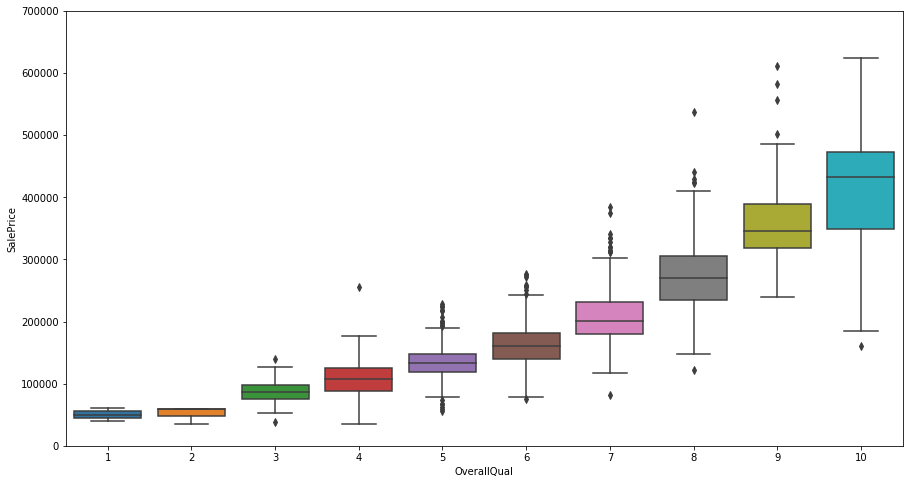

In [10]:
plt.subplots(figsize=(15,8))
sns.boxplot(x='OverallQual',y='SalePrice',data=my_data)
plt.ylim(0,700000)
plt.show()

#### It is clear from the graph better the quality more is the SalePrice

#### YearBuilt: Original construction date

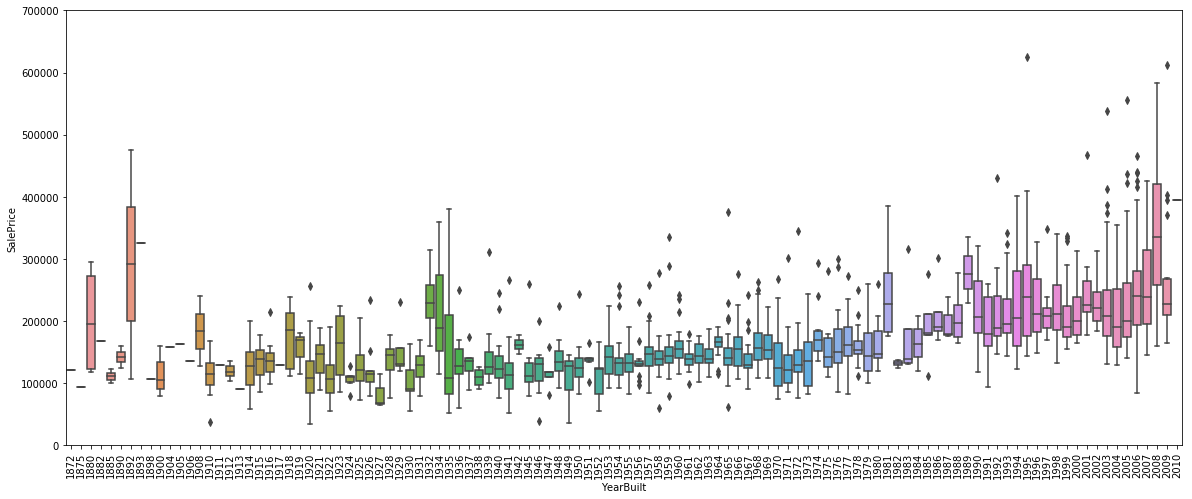

In [11]:
plt.subplots(figsize=(20,8))
sns.boxplot(x='YearBuilt',y='SalePrice',data=my_data)
plt.ylim(0,700000)
plt.xticks(rotation=90)
plt.show()

#####  Mostly Saleprice tends to raise if the house is newly built but it can't be said in general

### Till Now Summary
    'GrLivArea' and 'TotalBsmtSF' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF', we can see that the slope of the linear relationship is particularly high.
    'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.


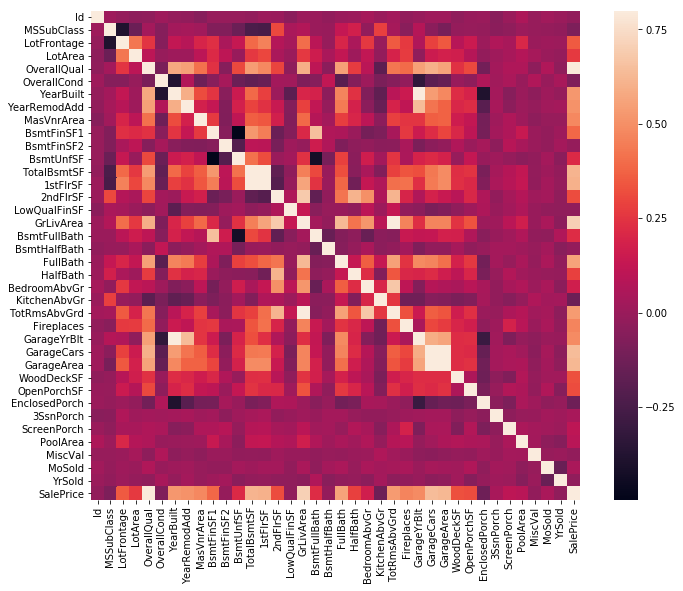

In [12]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(my_data.corr(),vmax=0.8,square=True)

In [13]:
corr_matrix=my_data.corr()

In [14]:
cols=corr_matrix.nlargest(10,'SalePrice')["SalePrice"].index

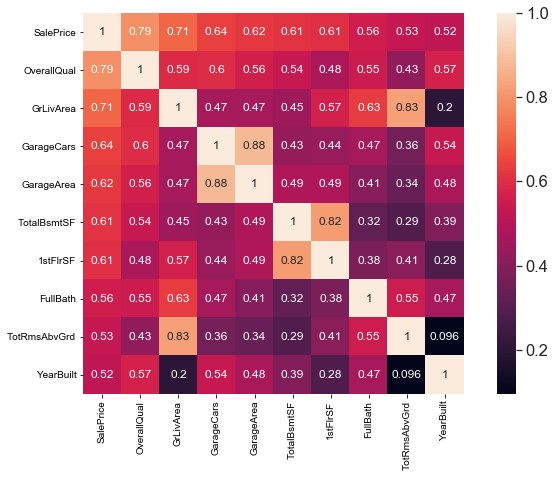

In [15]:
f, ax = plt.subplots(figsize=(12, 7))
cm=np.corrcoef(my_data[cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,cbar=True,annot=True,xticklabels=cols.values,yticklabels=cols.values,annot_kws={'size': 12},square=True)
plt.show()



According to our heat map, these are the variables most correlated with 'SalePrice'. My thoughts on this:

    'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!
    'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
    'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF'.
    'FullBath'?? Really?
    'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.
    Ah... 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'.

Let's proceed to the scatter plots.


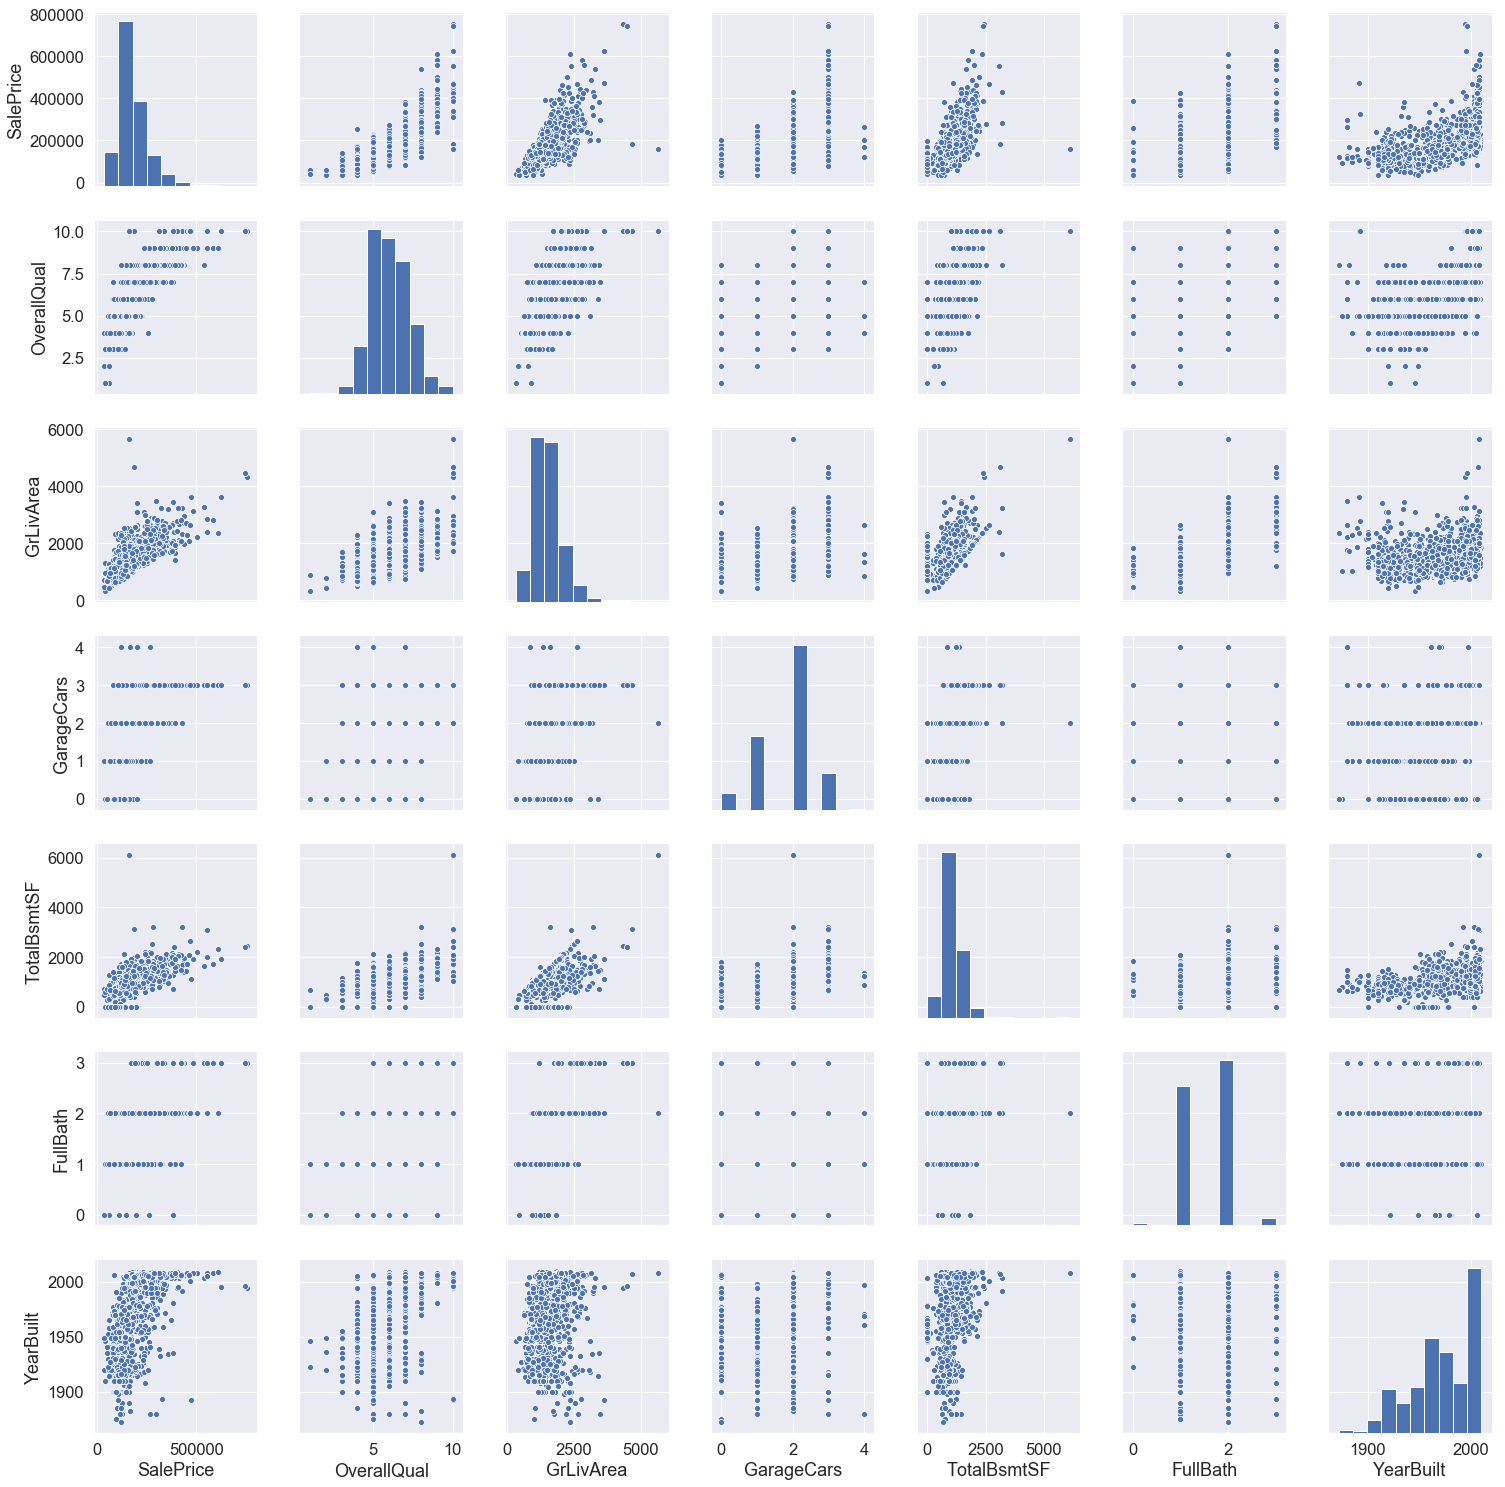

In [16]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(my_data[cols], size = 3)
plt.show();

## Missing Data

In [17]:
miss_data=my_data.isnull().sum().sort_values(ascending=False)
percent_miss=(my_data.isnull().sum()/my_data.isnull().count()).sort_values(ascending=False)
miss_Data=pd.concat([miss_data,percent_miss],axis=1,keys=['Total','Percent'])
miss_Data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [18]:
my_data=my_data.drop((miss_Data[miss_Data['Total']>1].index),axis=1)

In [19]:
my_data=my_data.drop(my_data.loc[my_data['Electrical'].isnull()].index)

In [20]:
my_data.isnull().sum().max()

0

### Now we have no null values

### Outliers

In [21]:
### The primary concern here is to establish a threshold that defines an observation as an outlier.
## To do so, we'll standardize the data. 
## In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

scaled_transform=StandardScaler().fit_transform(my_data['SalePrice'][:,np.newaxis])

In [22]:
scaled_transform

array([[ 0.34704187],
       [ 0.0071701 ],
       [ 0.53585953],
       ...,
       [ 1.07713679],
       [-0.48847623],
       [-0.42081658]])

In [23]:
low_range=scaled_transform[scaled_transform[:,0].argsort()][:10]
upper_range=scaled_transform[scaled_transform[:,0].argsort()][-10:]

In [24]:
print(low_range)

[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]


In [25]:
upper_range

array([[3.82758058],
       [4.0395221 ],
       [4.49473628],
       [4.70872962],
       [4.728631  ],
       [5.06034585],
       [5.42191907],
       [5.58987866],
       [7.10041987],
       [7.22629831]])

####  Low range values are similar and not too far from 0.
#### High range values are far from 0 and the 7.something values are really out of range.


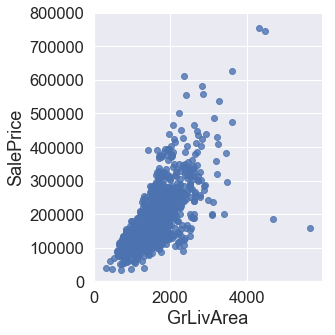

In [26]:
var='GrLivArea'
data=pd.concat([my_data['SalePrice'],my_data[var]],axis=1)
sns.lmplot(x=var,y='SalePrice',data=data,fit_reg=False)
plt.ylim( (0,800000))
plt.show()

##### We can see that there are two outliers (x> 4000) and these two outliers doesn't also follow the usual trend, hence we will drop them

In [27]:
my_data.sort_values(by='GrLivArea',ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [28]:
my_data=my_data.drop(my_data[my_data['Id']==1299].index)
my_data=my_data.drop(my_data[my_data['Id']==524].index)

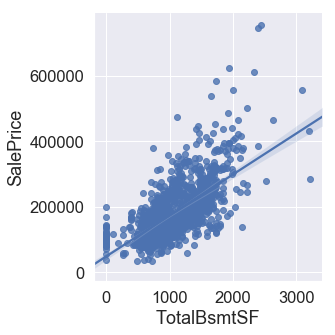

In [29]:
sns.lmplot(x='TotalBsmtSF',y='SalePrice',data=my_data,fit_reg=True)
plt.show()

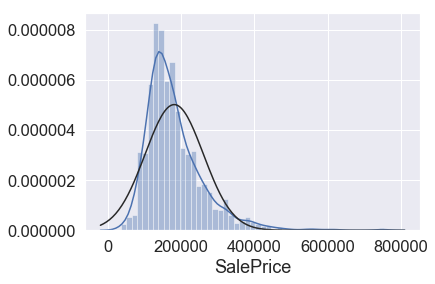

In [30]:
sns.distplot(my_data['SalePrice'],fit=norm)
plt.show()


((array([-3.30456314, -3.04731426, -2.90425334, ...,  2.90425334,
          3.04731426,  3.30456314]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74240.99917988208, 180942.13864104328, 0.9320520365889887))

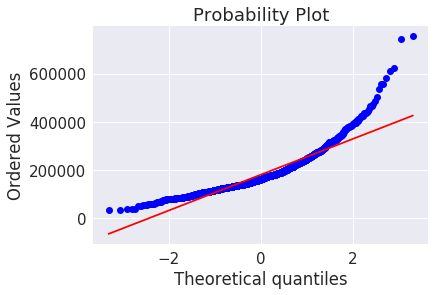

In [119]:
stats.probplot(my_data['SalePrice'],plot=plt)



Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

In [120]:
my_data["SalePrice"]=np.log(my_data['SalePrice'])

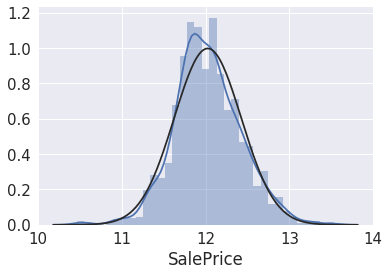

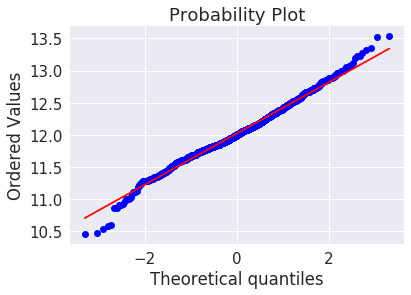

In [121]:
## After Log tranformation
sns.distplot(my_data['SalePrice'],fit=norm)
plt.figure()
stats.probplot(my_data['SalePrice'],plot=plt)
plt.show()

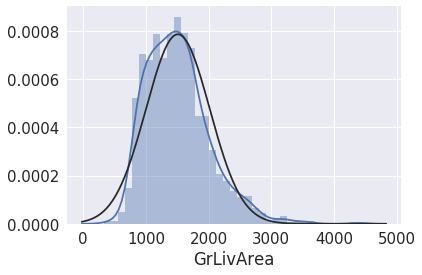

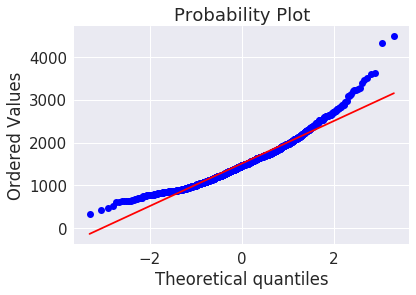

In [122]:
sns.distplot(my_data['GrLivArea'],fit=norm)
plt.figure()
stats.probplot(my_data["GrLivArea"],plot=plt)
plt.show()

In [123]:
my_data['GrLivArea']=np.log(my_data['GrLivArea'])

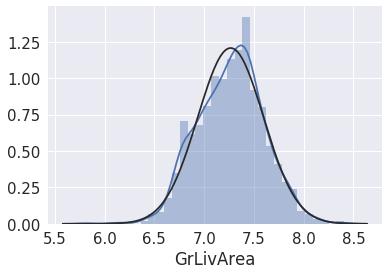

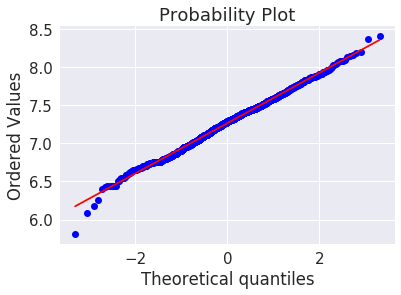

In [124]:
sns.distplot(my_data['GrLivArea'],fit=norm)
plt.figure()
stats.probplot(my_data["GrLivArea"],plot=plt)
plt.show()

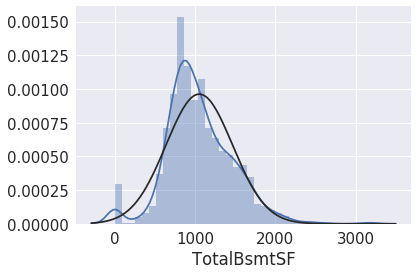

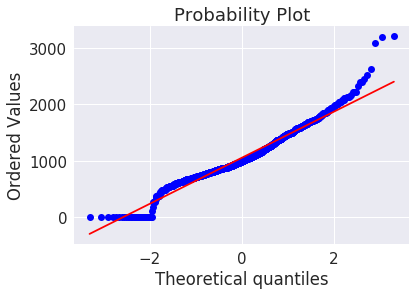

In [125]:
sns.distplot(my_data['TotalBsmtSF'],fit=norm)
plt.figure()
stats.probplot(my_data["TotalBsmtSF"],plot=plt)
plt.show()

## As lot of values are zero we can't take log transformation

In [126]:
my_data.loc[my_data['TotalBsmtSF']>0,'TotalBsmtSF']=np.log(my_data[my_data['TotalBsmtSF']>0]['TotalBsmtSF'])

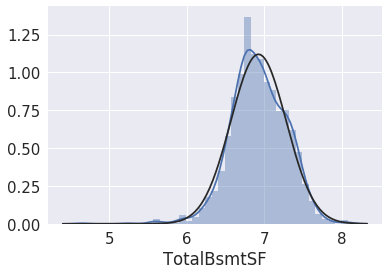

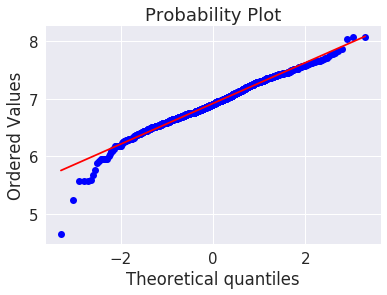

In [130]:
sns.distplot(my_data[my_data['TotalBsmtSF']>0]['TotalBsmtSF'],fit=norm)
plt.figure()
stats.probplot(my_data[my_data['TotalBsmtSF']>0]['TotalBsmtSF'],plot=plt)
plt.show()

In [131]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF','YearBuilt']

In [132]:
train_data=my_data[cols]

In [133]:
train_data.dtypes


SalePrice      int64
OverallQual    int64
GrLivArea      int64
GarageCars     int64
TotalBsmtSF    int64
YearBuilt      int64
dtype: object

In [135]:
##Converting YearBuilt to Categorical Variable
train_data['YearBuilt'] = train_data["YearBuilt"].astype(str)

In [136]:
train_data.dtypes


SalePrice       int64
OverallQual     int64
GrLivArea       int64
GarageCars      int64
TotalBsmtSF     int64
YearBuilt      object
dtype: object

In [137]:
## Using One Hot encoding
train_data=pd.get_dummies(train_data)
Y=train_data['SalePrice']
X=train_data.drop(['SalePrice'],axis=1)

In [138]:
train_X,test_X,train_Y,test_Y=train_test_split(X,Y)

#### First using the RandomForest for Prediction

In [139]:
model=RandomForestRegressor()
model.fit(train_X,train_Y)
predicted_Val_random_forest=model.predict(test_X)

In [140]:
error_random_forest=mean_absolute_error(predicted_Val_random_forest,test_Y)

In [141]:
error_random_forest

21490.748258317028

In [142]:
model_2=xg.XGBRegressor(n_estimators=1000,learning_rate=0.05)
model_2.fit(train_X,train_Y,early_stopping_rounds=8,eval_set=[(test_X,test_Y)])


[0]	validation_0-rmse:181145
Will train until validation_0-rmse hasn't improved in 8 rounds.
[1]	validation_0-rmse:172787
[2]	validation_0-rmse:164735
[3]	validation_0-rmse:157200
[4]	validation_0-rmse:149858
[5]	validation_0-rmse:143011
[6]	validation_0-rmse:136457
[7]	validation_0-rmse:130358
[8]	validation_0-rmse:124426
[9]	validation_0-rmse:118942
[10]	validation_0-rmse:113702
[11]	validation_0-rmse:108754
[12]	validation_0-rmse:104096
[13]	validation_0-rmse:99676.8
[14]	validation_0-rmse:95457.4
[15]	validation_0-rmse:91448.3
[16]	validation_0-rmse:87798.9
[17]	validation_0-rmse:84203.4
[18]	validation_0-rmse:80830
[19]	validation_0-rmse:77644.6
[20]	validation_0-rmse:74759.1
[21]	validation_0-rmse:71968.1
[22]	validation_0-rmse:69239.6
[23]	validation_0-rmse:66759.7
[24]	validation_0-rmse:64510.6
[25]	validation_0-rmse:62382.5
[26]	validation_0-rmse:60322.5
[27]	validation_0-rmse:58238.6
[28]	validation_0-rmse:56455.8
[29]	validation_0-rmse:54712.6
[30]	validation_0-rmse:53206.7


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [143]:
predicted_val_xgb=model_2.predict(test_X)
mean_absolute_error(predicted_val_xgb,test_Y)

20668.08961900685